In [1]:
%matplotlib notebook
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt
from flask import Flask, jsonify

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [5]:
engine = create_engine("sqlite:///hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

In [29]:
inspector = inspect(engine)

columns = inspector.get_columns('measurement')
for column in columns:
    print(column["name"], column["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


STEP 1

# Exploratory Climate Analysis

In [11]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
# Calculate the date 1 year ago from today
# Perform a query to retrieve the data and precipitation scores
# Save the query results as a Pandas DataFrame and set the index to the date column
# Sort the dataframe by date
# Use Pandas Plotting with Matplotlib to plot the data
# Rotate the xticks for the dates

# strip date into day,month, year
date =   [func.strftime("%d", Measurement.date),
         func.strftime("%m", Measurement.date),
         func.strftime("%Y", Measurement.date)]

# find last date in measurement table 
last_date = session.query(*date).order_by(Measurement.date.desc()).first()

#put into day/month/year
day = int(last_date[0])
month = int(last_date[1])
year = int(last_date[2])

#convert to datetime for timedelta calculation
last_date_datetime = dt.date(year,month,day)

#find date 12 months from last date
beg_date_12_months =  last_date_datetime - dt.timedelta(days=365)

precipitation_12_months = session.query(Measurement.date,Measurement.prcp).\
    filter(Measurement.date >= beg_date_12_months).all()
    


In [12]:
# Plot the Results in a Matplotlib bar chart
precipitation_df = pd.DataFrame(precipitation_12_months, columns=['Date', 'Precipitation'])

date_group = precipitation_df.groupby(by='Date')

precipitation_plot = pd.DataFrame(date_group['Precipitation'].sum())
precipitation_plot = precipitation_plot.reset_index()

precipitation_plot = precipitation_plot.sort_values(by='Date')



<IPython.core.display.Javascript object>


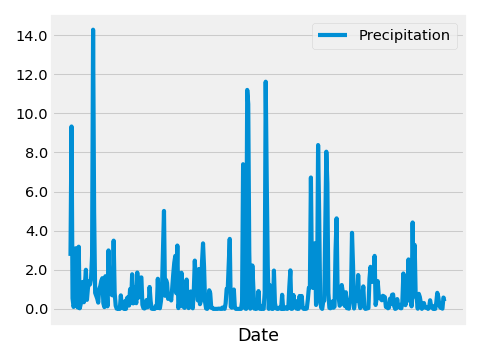

In [13]:
#plot 12 month data

ax = precipitation_plot.plot()
vals = ax.get_yticks()
ax.set_yticklabels(['{0:.1f}'.format(x) for x in vals])
plt.xlabel('Date')
plt.xticks(rotation=20)
plt.xticks([])
plt.tight_layout()
plt.show()    

In [14]:
# Use Pandas to calculate the summary statistics for the precipitation data

precipitation_data = session.query(Measurement.id,Measurement.station,Measurement.date,Measurement.prcp,Measurement.tobs).all()
precipitation_data_df = pd.DataFrame(precipitation_data, columns=['Id', 'Station', 'Date', 'Precipitation', 'TOBS'])

precipitation_data_df['Max Prcp'] = precipitation_data_df['Precipitation'].max()
precipitation_data_df['Min Prcp'] = precipitation_data_df['Precipitation'].min()
precipitation_data_df['Avg Prcp'] = precipitation_data_df['Precipitation'].mean()

precipitation_data_df['Max TOBS'] = precipitation_data_df['TOBS'].max()
precipitation_data_df['Min TOBS'] = precipitation_data_df['TOBS'].min()
precipitation_data_df['Avg TOBS'] = precipitation_data_df['TOBS'].mean()

precipitation_summary = precipitation_data_df[['Max Prcp','Min Prcp','Avg Prcp','Max TOBS','Min TOBS','Avg TOBS']].drop_duplicates()

precipitation_summary

,Max Prcp,Min Prcp,Avg Prcp,Max TOBS,Min TOBS,Avg TOBS
0,11.53,0.0,0.160644,87.0,53.0,73.097954


In [15]:
# How many stations are available in this dataset?
num_stations = session.query(Measurement).distinct(Measurement.station).group_by(Measurement.station).count()

print(f'Number of stations in dataset: {num_stations}')


Number of stations in dataset: 9


In [16]:
# What are the most active stations?
# List the stations and the counts in descending order.
active_stations = session.query(Measurement.station,func.count(Measurement.date).label("Num Measurements")).group_by(Measurement.station).\
        order_by(func.count(Measurement.date).desc())


[stations for stations in active_stations]



[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [17]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?
active_stations_list= []   
active_stations_list = [stations[0] for stations in active_stations]

temp_query = session.query(Measurement.station,
                           func.min(Measurement.tobs),
                           func.max(Measurement.tobs),   
                           func.avg(Measurement.tobs),
                           func.count(Measurement.date),
                          ).\
                          filter(Measurement.station.in_(active_stations_list)).\
                          group_by(Measurement.station).\
                          order_by(func.max(Measurement.tobs).desc()).all()

            
[temp for temp in temp_query]


[('USC00511918', 53.0, 87.0, 71.61596766043456, 1979),
 ('USC00517948', 58.0, 87.0, 74.68440233236151, 1372),
 ('USC00519397', 56.0, 87.0, 74.55323054331865, 2724),
 ('USC00513117', 59.0, 85.0, 72.68918420081211, 2709),
 ('USC00514830', 58.0, 85.0, 74.8732970027248, 2202),
 ('USC00519281', 54.0, 85.0, 71.66378066378067, 2772),
 ('USC00519523', 56.0, 85.0, 74.5436493068565, 2669),
 ('USC00516128', 58.0, 84.0, 70.91500765696784, 2612),
 ('USC00518838', 58.0, 83.0, 72.72407045009784, 511)]

<IPython.core.display.Javascript object>


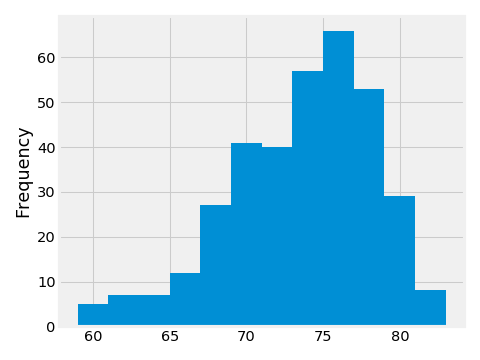

In [18]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

highest_temp_station = session.query(Measurement.date,Measurement.tobs).\
    filter(Measurement.date >= beg_date_12_months).\
    filter(Measurement.station == 'USC00519281').all()

highest_temp_station_df = pd.DataFrame(highest_temp_station, columns=['Date', 'Tobs'])
ax= highest_temp_station_df.hist(bins=12)
plt.ylabel('Frequency')
plt.title('')
plt.tight_layout()
plt.show()    

